In [290]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import seaborn as sb
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from pandas import read_excel, melt, DataFrame
from scipy.stats import  normaltest, bartlett, levene, ttest_ind

# 분산분석을 위한 라이브러리
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.oneway import anova_oneway # 등분산 충족하지 않을 때
from pingouin import anova
from pingouin import welch_anova

# 사후검정을 위한 라이브러리
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pingouin import pairwise_gameshowell, pairwise_tukey

In [253]:
plt.rcParams["font.family"] = 'AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams["font.size"] = 9
plt.rcParams["figure.figsize"] = (15, 6)
plt.rcParams["axes.unicode_minus"] = False

# 연습문제 (ANOVA)

## 문제 1

다음은 소나무 품종별 무게를 조사한 데이터이다.

분석하라.


| A    | B    | C    |
|------|------|------|
| 4.17 | 4.81 | 6.31 |
| 5.58 | 4.17 | 5.12 |
| 5.18 | 4.41 | 5.54 |
| 6.11 | 3.59 | 5.5  |
| 4.5  | 5.87 | 5.37 |
| 4.61 | 3.83 | 5.29 |
| 5.17 | 6.03 | 4.92 |
| 4.53 | 4.89 | 6.15 |
| 5.33 | 4.32 | 5.8  |
| 5.14 | 4.69 | 5.26 |

> https://data.hossam.kr/mldata/tree_weight.xlsx

### [1] 데이터 가져오기

In [254]:
df1 = read_excel('https://data.hossam.kr/mldata/tree_weight.xlsx')
df1 # 일원분산분석

,weight,group
0,4.17,A
1,5.58,A
2,5.18,A
3,6.11,A
4,4.50,A
5,4.61,A
6,5.17,A
7,4.53,A
8,5.33,A
9,5.14,A


### [2] 커널 밀도함수 및 신뢰구간 확인

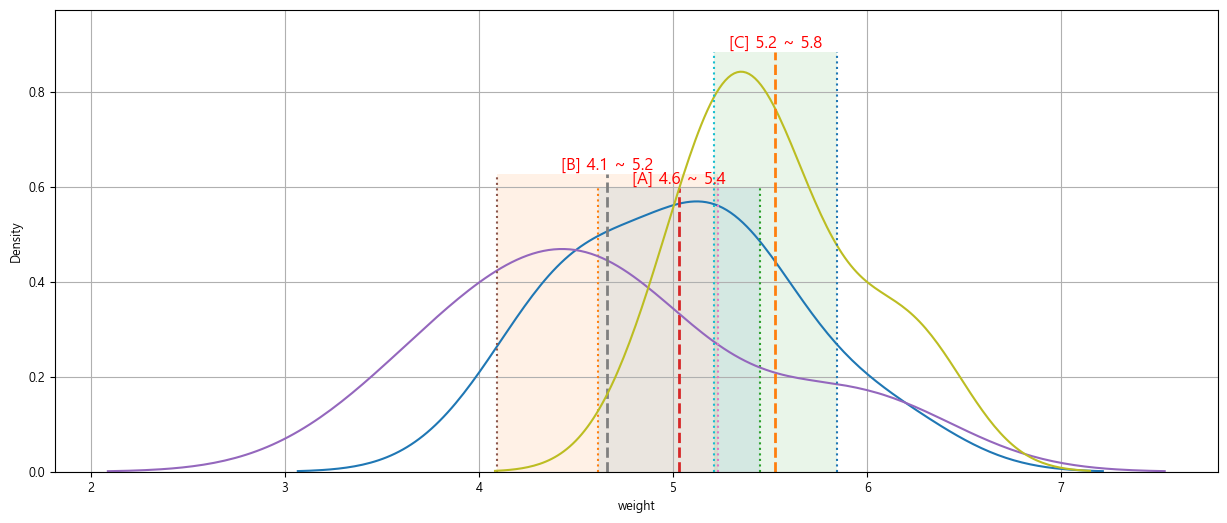

In [255]:
plt.figure()
for c in df1['group'].unique():
    #print(c)
    
    data = df1[df1['group']==c]['weight']
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차
    
    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [ymin, ymax], linestyle=':')
    plt.plot([cmax, cmax], [ymin, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=ymin, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [ymin, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(0, ymax*1.1)
plt.grid()
plt.show()
plt.close()

In [256]:
df1.head()

,weight,group
0,4.17,A
1,5.58,A
2,5.18,A
3,6.11,A
4,4.50,A


### [3] 가설검정의 가정 확인

In [257]:
normal_dist = True      # 정규성 만족 여부
fields = []
for c in df1['group'].unique():
    data = df1[df1['group']==c]['weight']
    s, p = normaltest(data)
    # s, p = shapiro(data)
    fields.append(data)
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))
    normal_dist = normal_dist and (p>0.05)

if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*fields)
else:
    n = "Levene"
    s, p = levene(*fields)
    
print("{0} 검정: statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, p > 0.05))

[A] statistic: 0.233, p-value: 0.890, 정규성 충족 여부: True
[B] statistic: 0.968, p-value: 0.616, 정규성 충족 여부: True
[C] statistic: 1.013, p-value: 0.603, 정규성 충족 여부: True
Bartlett 검정: statistic: 2.879, p-value: 0.237, 등분산성 충족 여부: True


### [4] 일원분산분석 수행
#### (1) statsmodels 패키지를 사용한 방법

In [258]:
lm = ols('weight ~ C(group)', data=df1).fit() # y = ax+b :: sales ~ C(store) ; R에서 쓰는 형식
anova_result = anova_lm(lm)
s = anova_result['F'][0]
p = anova_result['PR(>F)'][0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 4.846, p-value: 0.016, 대립가설 채택'

#### (2) pingouin 패키지를 사용한 방법

In [259]:
anova(data=df1,dv='weight',between ='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,27,4.846088,0.01591,0.264148


### [5] 사후검정 수행
#### (1) statsmodels 패키지를 사용한 방법

In [260]:
tukey = pairwise_tukeyhsd(df1['weight'], df1['group'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,-0.371,0.3909,-1.0622,0.3202,False
A,C,0.494,0.198,-0.1972,1.1852,False
B,C,0.865,0.012,0.1738,1.5562,True


> 그룹B와 그룹C의 평균이 유의미한 차이를 보인다.
>
> 평균의 차이는 0.865로 95%의 신뢰구간은 0.1738 ~ 1.5562 이다.
>
> A-B, A-C는 다르지 않다.

#### (2) pingouin 패키지를 사용한 방법

In [261]:
pairwise_tukey(data = df1, dv= 'weight', between = 'group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,5.032,4.661,0.371,0.278782,1.330791,0.390871,0.510237
1,A,C,5.032,5.526,-0.494,0.278782,-1.771996,0.197996,-0.914038
2,B,C,4.661,5.526,-0.865,0.278782,-3.102787,0.012006,-1.289277


## 문제 2

다음은 독극물 종류별로 동물의 생존시간을 기록한 실험 데이터의 일부이다.

| time | poison | treat |
|------|--------|-------|
| 0.31 | 1      | A     |
| 0.45 | 1      | A     |
| 0.46 | 1      | A     |
| 0.43 | 1      | A     |
| 0.36 | 2      | A     |


> https://data.hossam.kr/mldata/poisons.xlsx

데이터의 각 변수는 다음과 같다.

| 필드 | 설명 |
|--|--|
| Time | 동물의 생존시간 |
| poison | 사용된 독극물 종류 |
| treat | 사용되는 치료 유형 |

사용된 독극물 종류와 치료 유형에 유의미한 차이가 있는지 분석하라.

### [1] 데이터 가져오기

In [262]:
df2 = read_excel('https://data.hossam.kr/mldata/poisons.xlsx')
df2 # 이원분산분석

,time,poison,treat
0,3.8,P1,T1
1,2.7,P1,T1
2,1.7,P1,T1
3,2.2,P1,T1
4,0.7,P1,T1
...,...,...,...
355,4.7,P3,T4
356,4.9,P3,T4
357,4.9,P3,T4
358,4.5,P3,T4


### [2] 커널 밀도함수 및 신뢰구간 확인

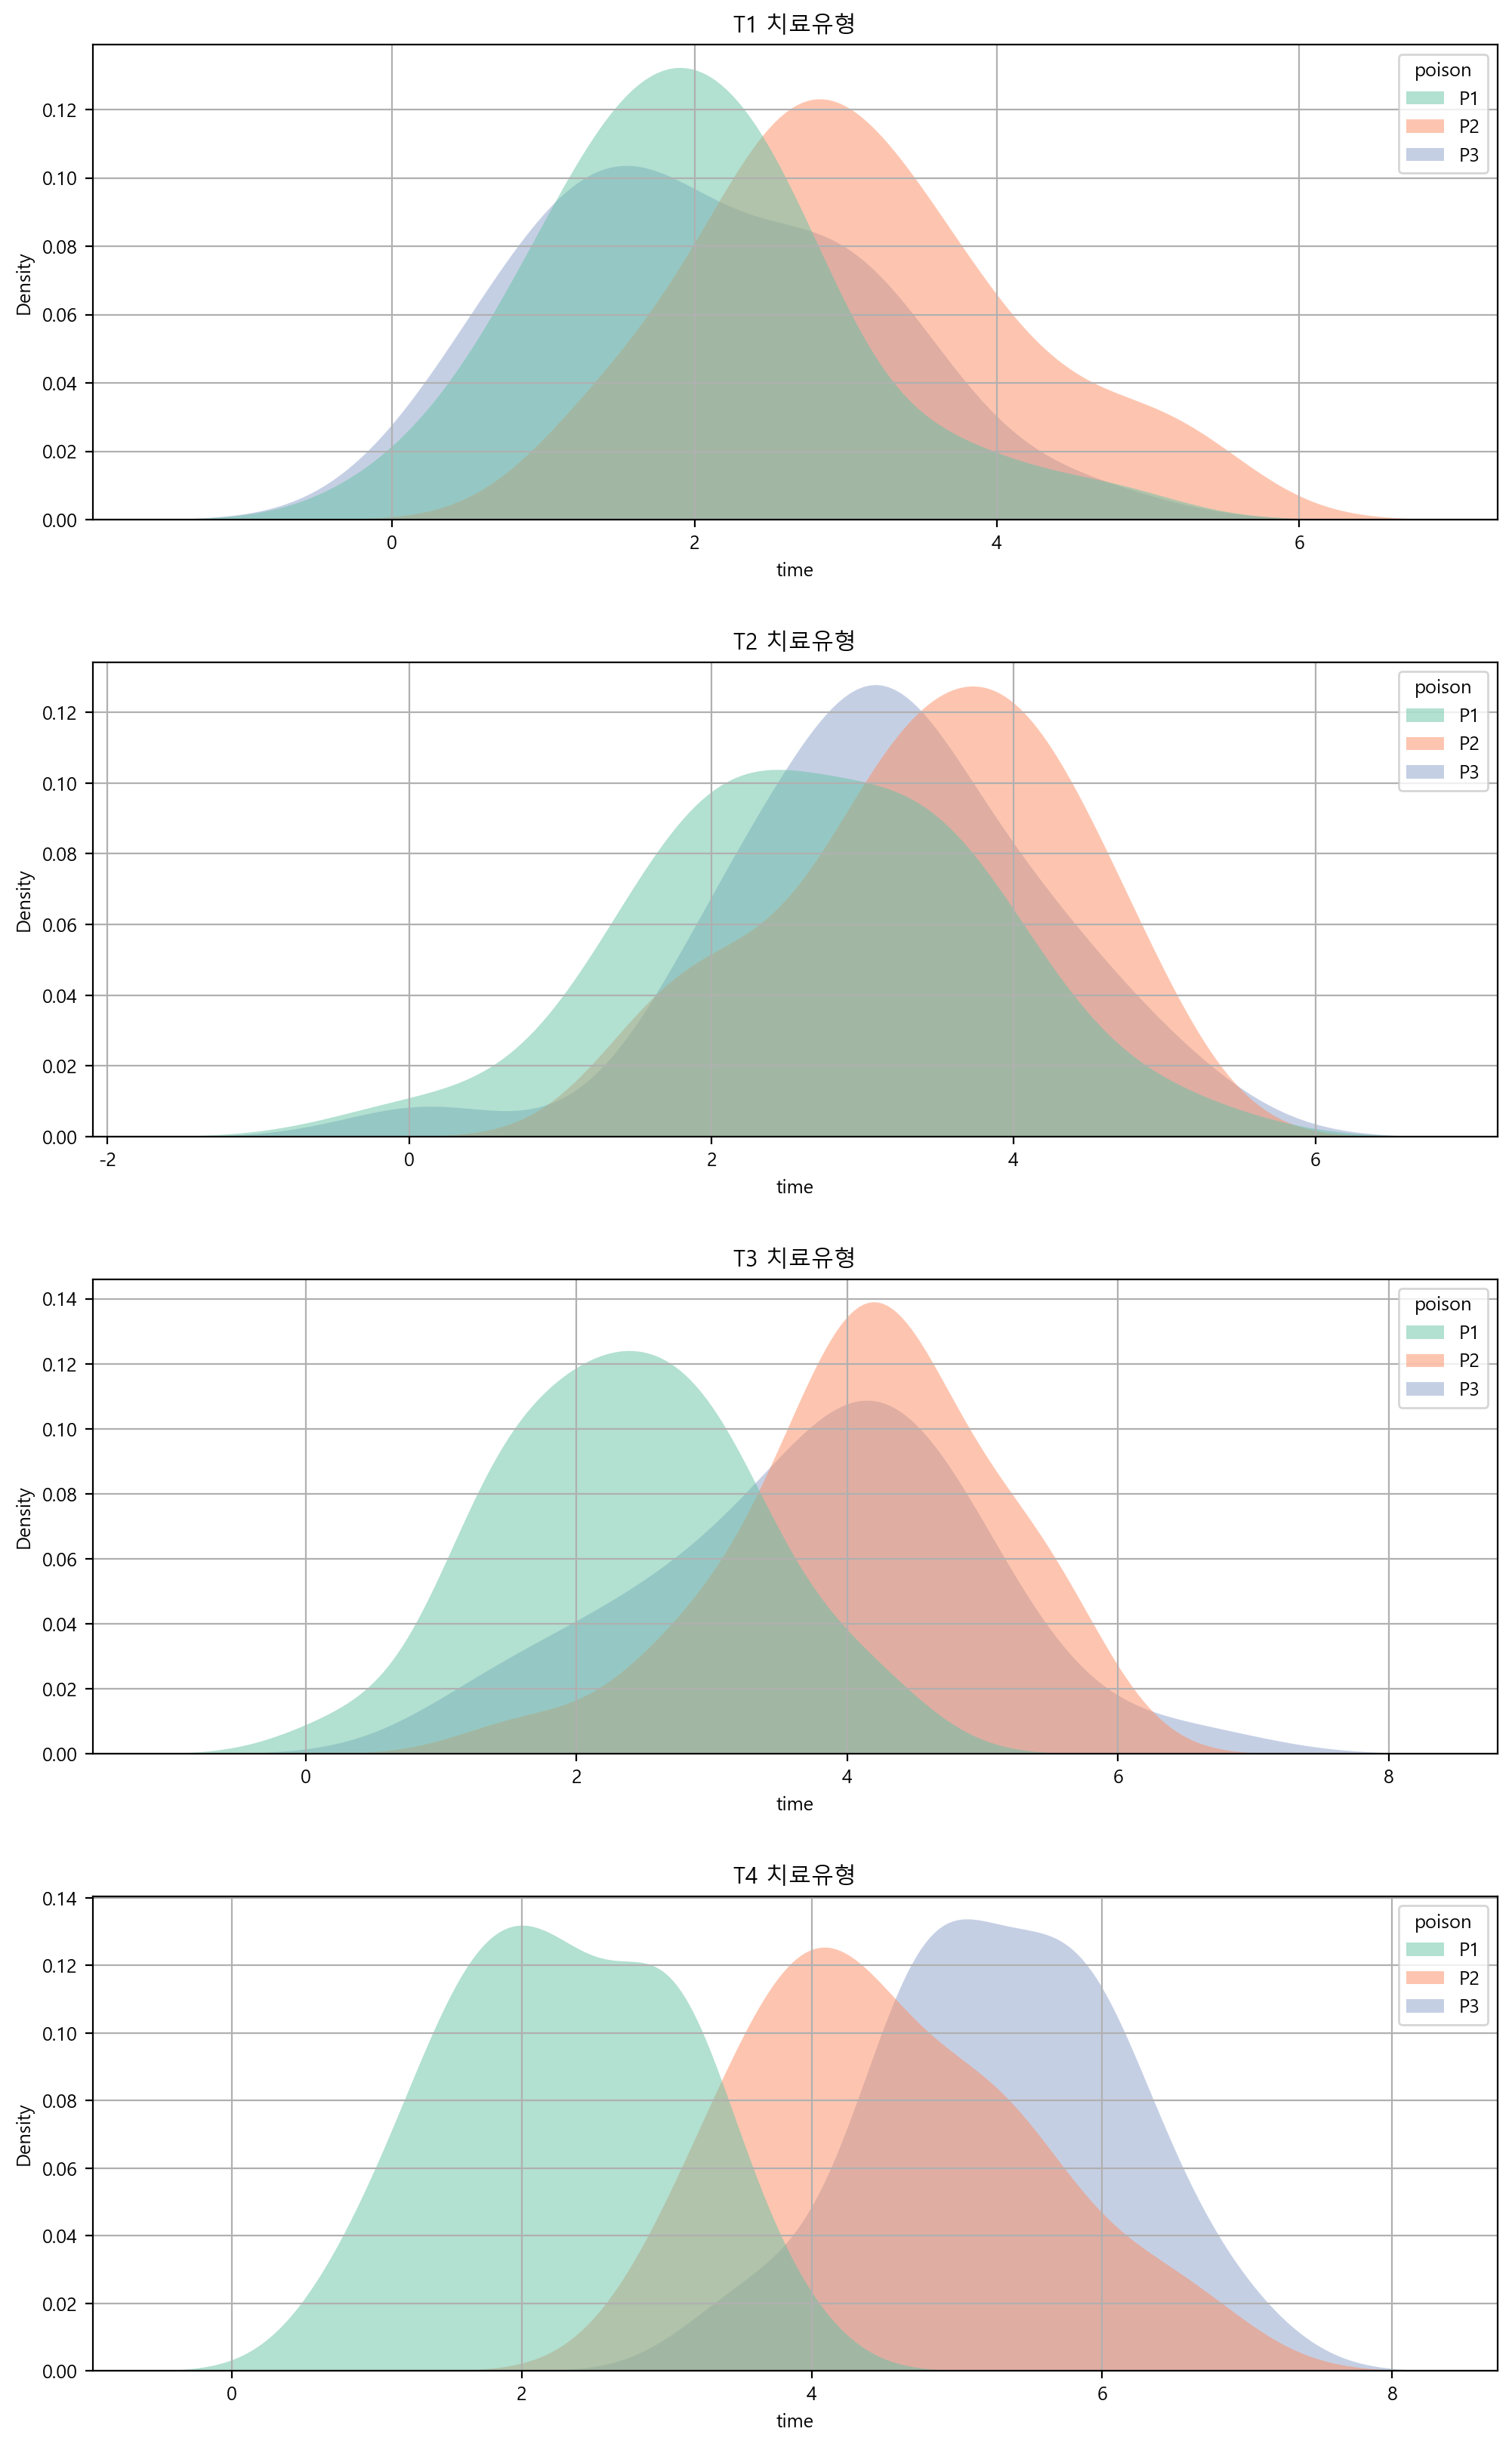

In [263]:
fields = df2['treat'].unique()
l = len(fields)
fig, ax = plt.subplots(l, 1, figsize=(12, 5*l), dpi=200)
fig.subplots_adjust(hspace=0.3)

for i, v in enumerate(ax):
    sb.kdeplot(data=df2[df2['treat']==fields[i]], x='time', hue='poison', palette='Set2', 
               fill=True, alpha=.5, linewidth=0, ax=v)
    v.grid()
    v.set_title(f'{fields[i]} 치료유형')
plt.show()
plt.close()

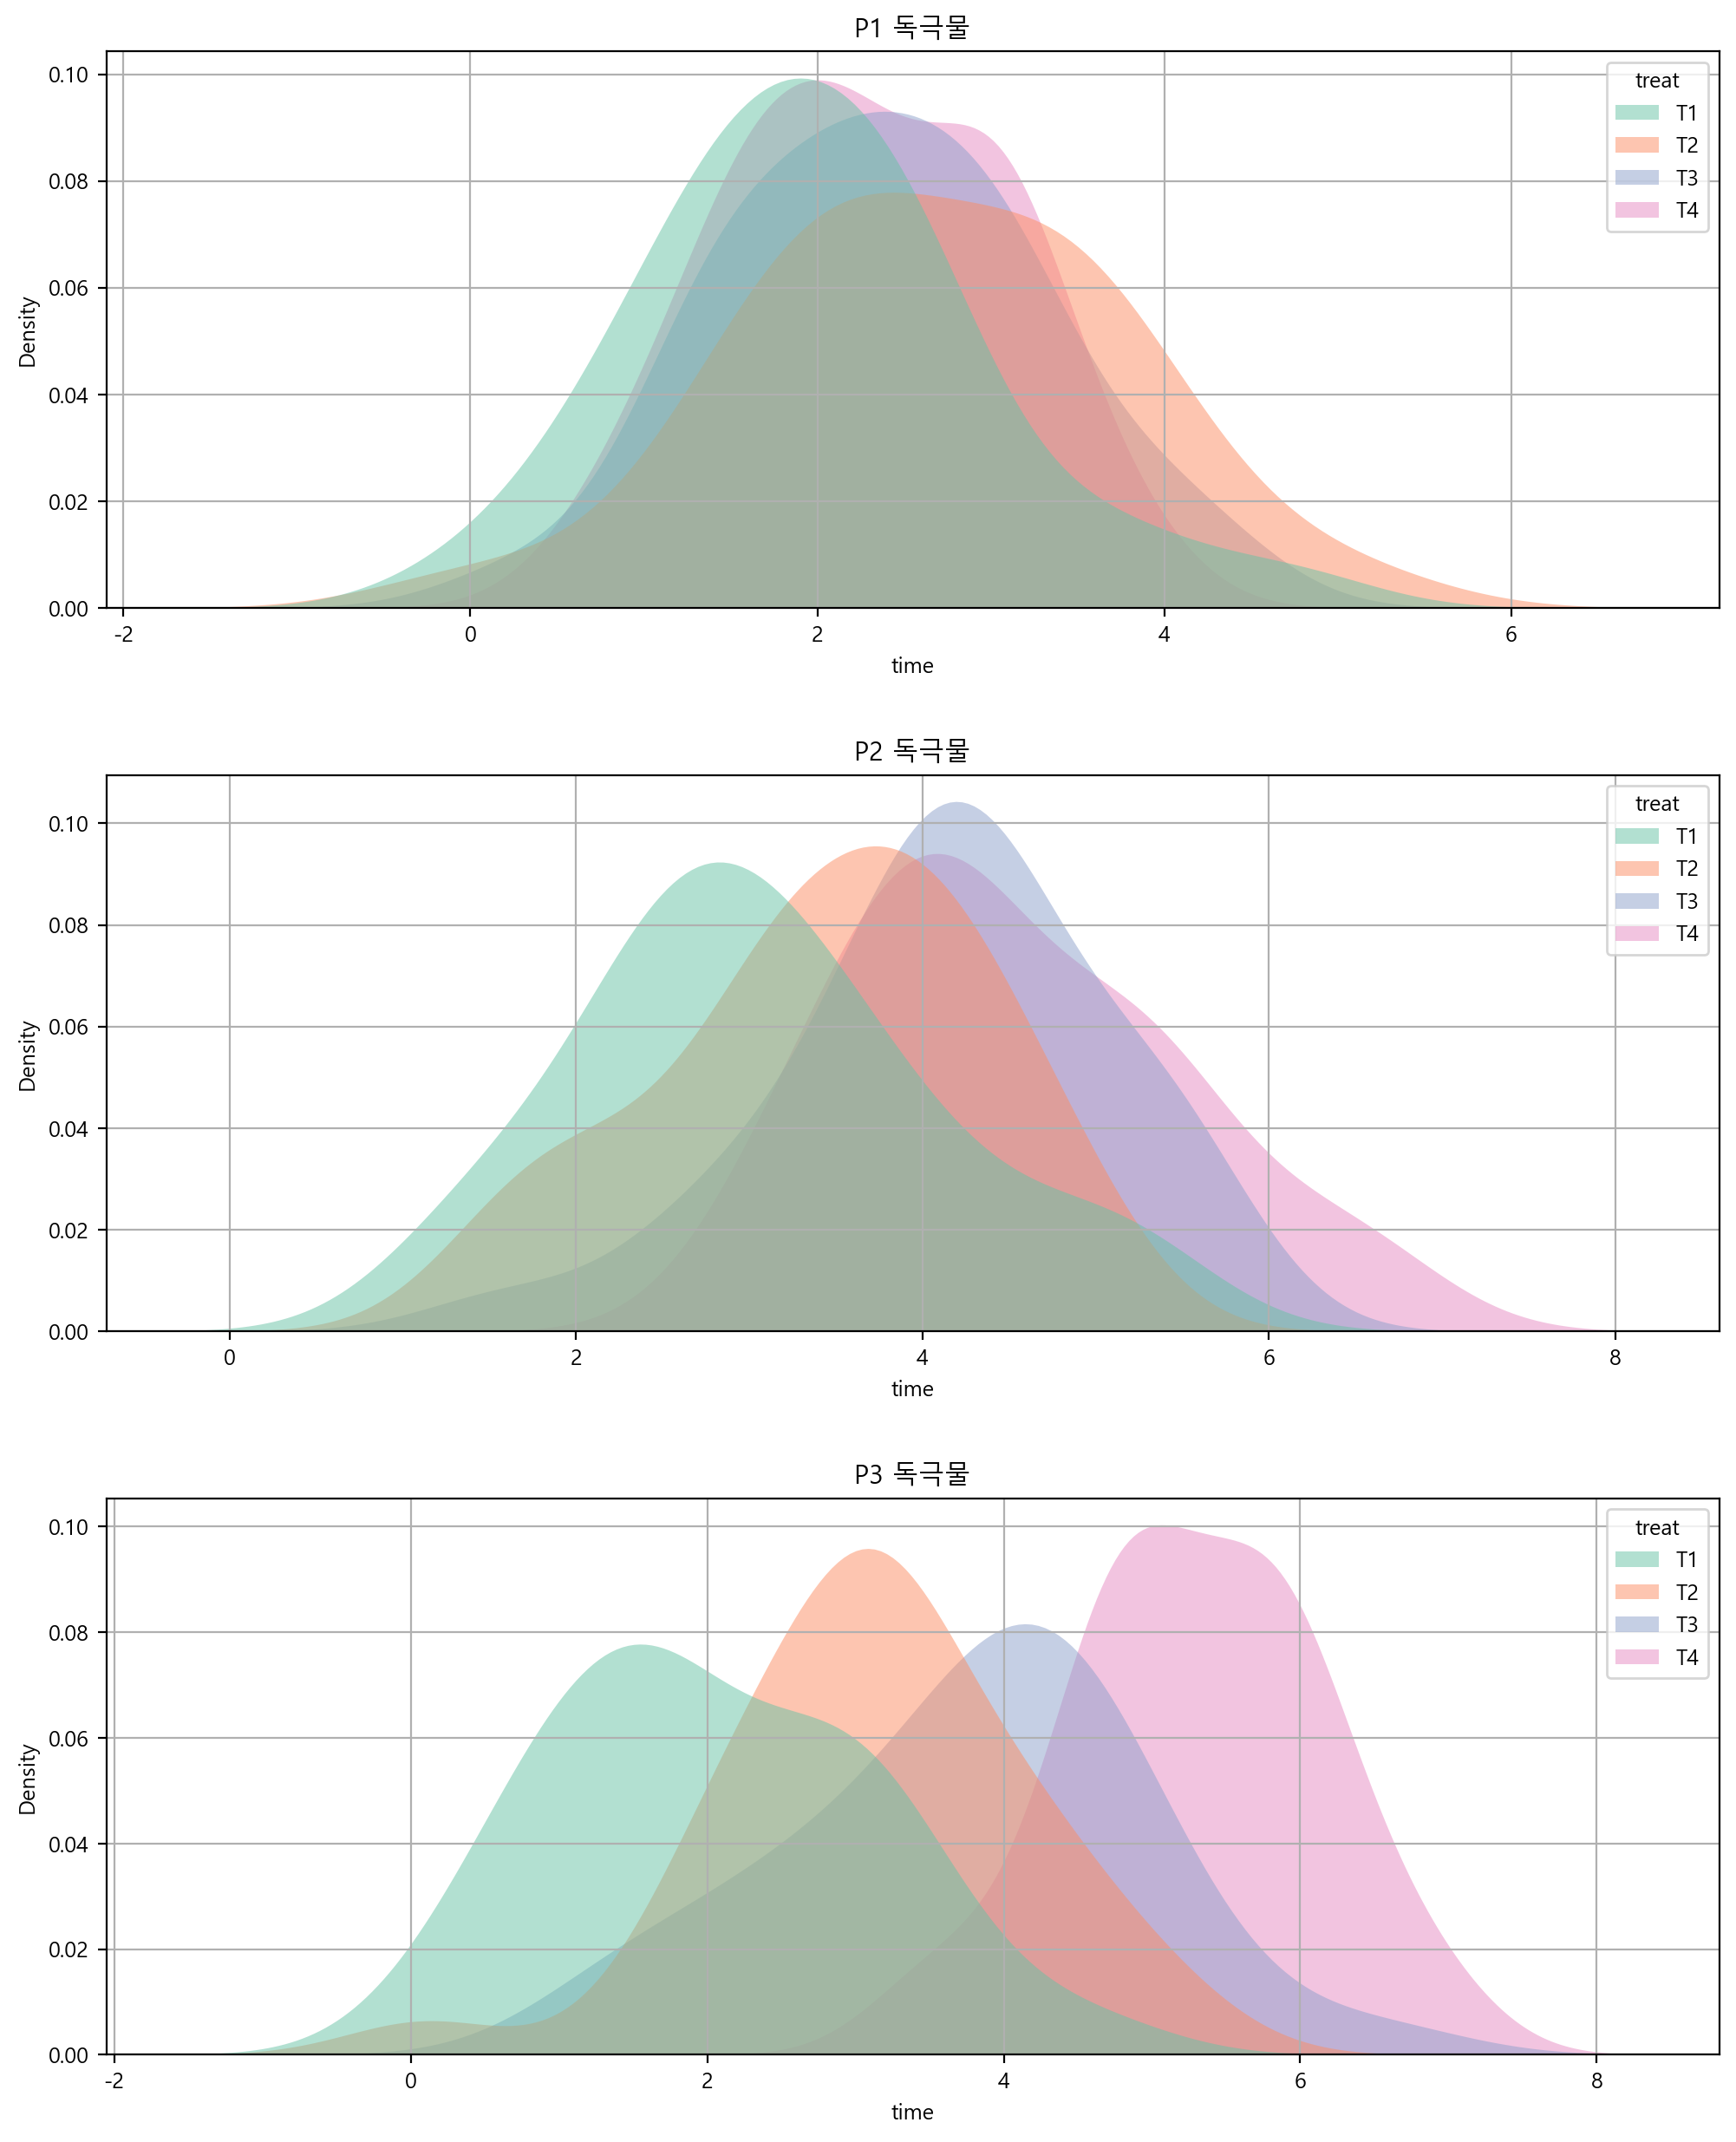

In [264]:
fields = df2['poison'].unique()
l = len(fields)
fig, ax = plt.subplots(l, 1, figsize=(12, 5*l), dpi=200)
fig.subplots_adjust(hspace=0.3)

for i, v in enumerate(ax):
    sb.kdeplot(data=df2[df2['poison']==fields[i]], x='time', hue='treat', palette='Set2', 
               fill=True, alpha=.5, linewidth=0, ax=v)
    v.grid()
    v.set_title(f'{fields[i]} 독극물')
plt.show()
plt.close()

### [3] 가설검정의 가정 확인

In [265]:
fields = []
normal_dist = True      # 정규성 만족 여부

for i in df2['poison'].unique():
    for j in df2['treat'].unique():
        data = df2[(df2['poison'] == i) & (df2['treat'] == j)]['time']
        s, p = normaltest(data)
        print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(i +" + " + j, s, p, p > 0.05))
        # s, p = shapiro(data)
        fields.append(data)
        
        normal_dist = normal_dist and p > 0.05

if normal_dist:
    s, p = bartlett(*fields)
else:
    s, p = levene(*fields)
print("{f0} Test Result \nstatistic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}".format(s, p, p > 0.05,f0 = 'bartlett' if normal_dist else 'levene'))

[P1 + T1] statistic: 3.661, p-value: 0.160, 정규성 충족 여부: True
[P1 + T2] statistic: 0.266, p-value: 0.875, 정규성 충족 여부: True
[P1 + T3] statistic: 0.014, p-value: 0.993, 정규성 충족 여부: True
[P1 + T4] statistic: 1.476, p-value: 0.478, 정규성 충족 여부: True
[P2 + T1] statistic: 1.112, p-value: 0.573, 정규성 충족 여부: True
[P2 + T2] statistic: 1.510, p-value: 0.470, 정규성 충족 여부: True
[P2 + T3] statistic: 2.802, p-value: 0.246, 정규성 충족 여부: True
[P2 + T4] statistic: 1.662, p-value: 0.436, 정규성 충족 여부: True
[P3 + T1] statistic: 0.837, p-value: 0.658, 정규성 충족 여부: True
[P3 + T2] statistic: 3.667, p-value: 0.160, 정규성 충족 여부: True
[P3 + T3] statistic: 0.425, p-value: 0.809, 정규성 충족 여부: True
[P3 + T4] statistic: 0.164, p-value: 0.921, 정규성 충족 여부: True
bartlett Test Result 
statistic: 8.154, p-value: 0.699, 등분산성 충족 여부: True


### [4] 분산분석 수행
#### (1) statsmodels 패키지

In [266]:
formula = 'time ~ C(poison)*C(treat)'
lm = ols(formula, df2).fit()
anova_result = anova_lm(lm)
anova_result

,df,sum_sq,mean_sq,F,PR(>F)
C(poison),2.0,148.976389,74.488194,74.722166,1.002877e-27
C(treat),3.0,131.260972,43.753657,43.891090,4.430485e-24
C(poison):C(treat),6.0,81.381611,13.563602,13.606206,6.938981e-14
Residual,348.0,346.910333,0.996869,NaN,NaN


> 독극물 종류에 따른 생존시간은 통계적으로 유의미한 차이를 보인다 ($P \leqq 0.05$)
> 
> 치료방법에 따른 생존시간은 통계적으로 유의미한 차이를 보인다 ($P \leqq 0.05$)
> 
> 독극물 종류와 치료방법에는 교효작용이 있는 것으로 보인다 ($P \leqq 0.05$)

#### (2) pingouin 패키지

In [267]:
anova(data=df2, dv='time', between=['poison', 'treat'])

,Source,SS,DF,MS,F,p-unc,np2
0,poison,148.976389,2,74.488194,74.722166,1.002877e-27,0.300424
1,treat,131.260972,3,43.753657,43.891090,4.430485e-24,0.274506
2,poison * treat,81.381611,6,13.563602,13.606206,6.938981e-14,0.190014
3,Residual,346.910333,348,0.996869,NaN,NaN,NaN


## 문제 3

효소 성분의 비료가 효소 함량이 증가함에 따라 토마토 모종 포기의 성장에 어떤 영향을 주는지 실험연구를 하여 다음 자료를 얻었다.

분산분석을 하여 효소 함량에 따라 토마토 모종 성장에 차이가 나는지 검정하라.

<table>
    <tr>
        <th>효소함량</th>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>0</td>
        <td>1000</td>
        <td>1000</td>
        <td>1000</td>
        <td>1000</td>
        <td>5000</td>
        <td>5000</td>
        <td>5000</td>
        <td>5000</td>
        <td>10000</td>
        <td>10000</td>
        <td>10000</td>
        <td>10000</td>
    </tr>
    <tr>
        <th>모종성장</th>
        <td>10.8</td>
        <td>9.1</td>
        <td>13.5</td>
        <td>9.2</td>
        <td>11.1</td>
        <td>11.2</td>
        <td>8.2</td>
        <td>11.3</td>
        <td>5.4</td>
        <td>4.6</td>
        <td>7.4</td>
        <td>5</td>
        <td>5.8</td>
        <td>5.3</td>
        <td>3.2</td>
        <td>7.5</td>
    </tr>
</table>

> https://data.hossam.kr/mldata/tomato.xlsx

### [1] 데이터 가져오기

In [268]:
df3 = read_excel('https://data.hossam.kr/mldata/tomato.xlsx')
df3 # 일원분산분석

,효소함량,모종성장
0,0,9.5
1,0,10.0
2,0,10.7
3,0,9.0
4,0,12.4
...,...,...
85,1000,15.8
86,1000,14.5
87,1000,13.5
88,1000,15.0


### [2] 커널 밀도함수 및 신뢰구간 확인

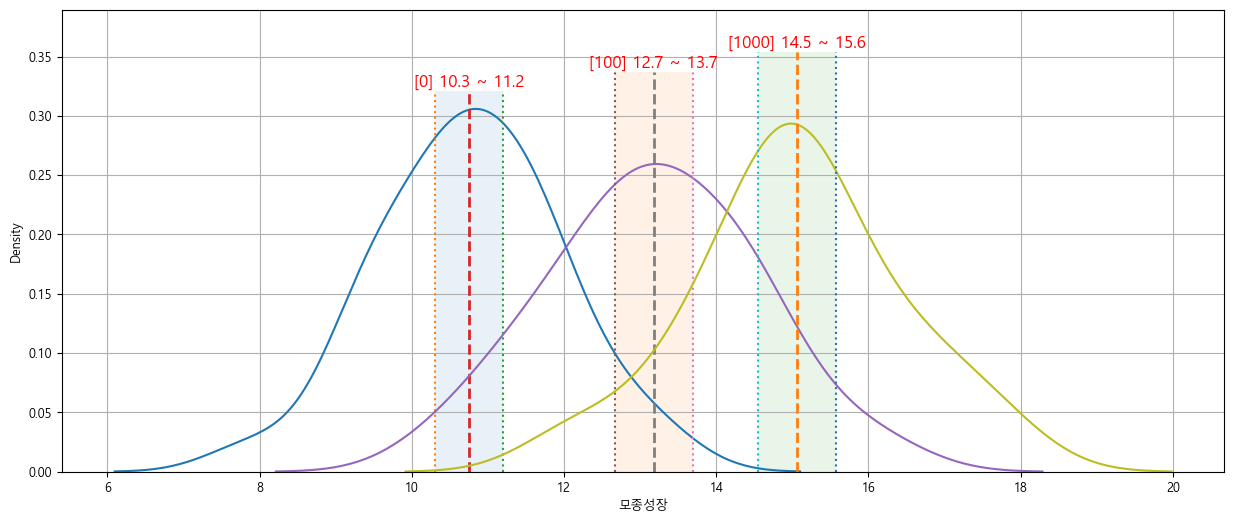

In [269]:
plt.figure()
for c in df3['효소함량'].unique():
    #print(c)
    
    data = df3[df3['효소함량']==c]['모종성장']
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차
    
    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [ymin, ymax], linestyle=':')
    plt.plot([cmax, cmax], [ymin, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=ymin, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [ymin, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(0, ymax*1.1)
plt.grid()
plt.show()
plt.close()

### [3] 가설검정의 가정 확인

In [270]:
fields = []
normal_dist = True      # 정규성 만족 여부
   
for c in df3['효소함량'].unique():
    data = df3[df3['효소함량']==c]['모종성장']
    s, p = normaltest(data)
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05)) 
    fields.append(data)
    
    normal_dist = normal_dist and p > 0.05

if normal_dist:
    s, p = bartlett(*fields)
else:
    s, p = levene(*fields)
print("{f0} Test Result \nstatistic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}".format(s, p, p > 0.05,f0 = 'bartlett' if normal_dist else 'levene'))

[0] statistic: 0.238, p-value: 0.888, 정규성 충족 여부: True
[100] statistic: 0.000, p-value: 1.000, 정규성 충족 여부: True
[1000] statistic: 0.235, p-value: 0.889, 정규성 충족 여부: True
bartlett Test Result 
statistic: 0.776, p-value: 0.678, 등분산성 충족 여부: True


### [4] 분산분석 수행
#### (1) statsmodels 패키지 사용

In [271]:
lm = ols('모종성장 ~ C(효소함량)', data=df3).fit()
anova_result = anova_lm(lm)
s = anova_result['F'][0]
p = anova_result['PR(>F)'][0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무")

'statistic: 81.094, p-value: 0.000, 대립가설 채택'

>  유의미한 차이가 있다.($ P \leqq 0.05 $)   
>
> $\leqq$, $<$ : p-value가 정확히 0.05인 경우가 없으므로 둘다 동일한 의미로 사용된다.

#### (2) pingouin 패키지 사용

In [273]:
anova(data=df3, dv='모종성장', between='효소함량')

,Source,ddof1,ddof2,F,p-unc,np2
0,효소함량,2,87,81.094169,1.318657e-20,0.650866


### [5] 사후검정 수행
#### (1) statsmodels 패키지

In [274]:
tukey = pairwise_tukeyhsd(df3['모종성장'], df3['효소함량'])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0,100,2.4267,0.0,1.6187,3.2346,True
0,1000,4.3033,0.0,3.4954,5.1113,True
100,1000,1.8767,0.0,1.0687,2.6846,True


> 효소함량에 따른 토마토의 성장은 전체적으로 차이가 있다. 효소의 함량이 많을 수록 토마토 성장이 훨씬 잘 이루어 진다.
>
> 'meandiff' 값이 +값이므로 효소 함량이 많을수록 큼

#### (2) pingouin 패키지

In [275]:
pairwise_tukey(data=df3, dv='모종성장', between='효소함량')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,0,100,10.753333,13.180000,-2.426667,0.338824,-7.162024,7.228520e-10,-1.867526
1,0,1000,10.753333,15.056667,-4.303333,0.338824,-12.700788,2.220446e-15,-3.315507
2,100,1000,13.180000,15.056667,-1.876667,0.338824,-5.538763,9.517362e-07,-1.350914


## 문제 4

유아들을 대상으로 세 가지 읽는 방법을 비교,실험하여 다음과 같은 독서평가 점수자료를 얻었다.

세 방법에 통계적으로 유의한 차이가 있는지 검정하라.

<table>
    <tr>
        <th>독서방법</th>
        <td>B</td>
        <td>B</td>
        <td>B</td>
        <td>B</td>
        <td>D</td>
        <td>D</td>
        <td>D</td>
        <td>D</td>
        <td>D</td>
        <td>S</td>
        <td>S</td>
        <td>S</td>
        <td>S</td>
        <td>S</td>
    </tr>
    <tr>
        <th>점수</th>
        <td>6</td>
        <td>9</td>
        <td>2</td>
        <td>16</td>
        <td>7</td>
        <td>7</td>
        <td>12</td>
        <td>10</td>
        <td>16</td>
        <td>11</td>
        <td>7</td>
        <td>4</td>
        <td>7</td>
        <td>7</td>
    </tr>
</table>

> https://data.hossam.kr/mldata/reading.xlsx

### [1] 데이터 가져오기

In [276]:
df4 = read_excel('https://data.hossam.kr/mldata/reading.xlsx')
df4 # 일원분산분석

,독서방법,점수
0,B,7.7
1,B,1.5
2,B,4.3
3,B,5.4
4,B,4.3
...,...,...
85,G,13.6
86,G,18.4
87,G,17.0
88,G,11.7


### [2] 커널 밀도함수 및 신뢰구간 확인

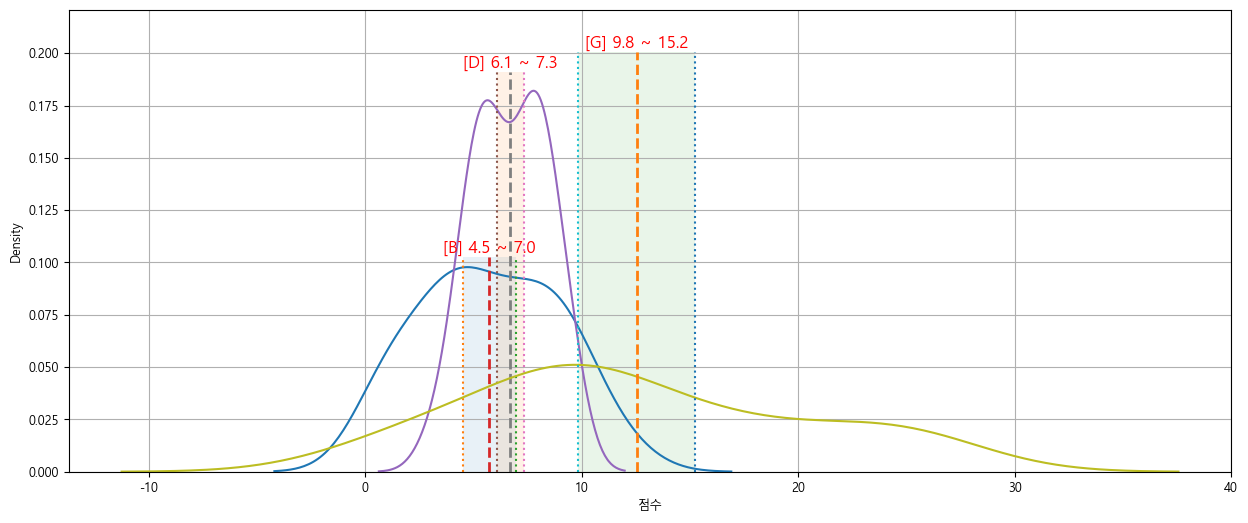

In [277]:
plt.figure()
for c in df4['독서방법'].unique():
    #print(c)
    
    data = df4[df4['독서방법']==c]['점수']
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차
    
    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [ymin, ymax], linestyle=':')
    plt.plot([cmax, cmax], [ymin, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=ymin, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [ymin, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(0, ymax*1.1)
plt.grid()
plt.show()
plt.close()

### [3] 가설검정의 가정 확인

In [278]:
fields = []
normal_dist = True      # 정규성 만족 여부
   
for c in df4['독서방법'].unique():
    data = df4[df4['독서방법']==c]['점수']
    s, p = normaltest(data)
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))
    # s, p = shapiro(data)
    # print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(c, s, p, p > 0.05))
    fields.append(data)
    
    normal_dist = normal_dist and p > 0.05

if normal_dist:
    s, p = bartlett(*fields)
else:
    s, p = levene(*fields)
print("{f0} Test Result \nstatistic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}".format(s, p, p > 0.05,f0 = 'bartlett' if normal_dist else 'levene'))

[B] statistic: 2.210, p-value: 0.331, 정규성 충족 여부: True
[D] statistic: 2.397, p-value: 0.302, 정규성 충족 여부: True
[G] statistic: 2.217, p-value: 0.330, 정규성 충족 여부: True
bartlett Test Result 
statistic: 58.099, p-value: 0.000, 등분산성 충족 여부: False


### [4] 분산분석 수행

등분산성을 충족하지 않으므로 웰치 검정을 수행해야 한다.

#### (1) statsmodels 패키지 사용

In [279]:
# 등분산성을 만족하지 못하는 경우 다른 방법을 수행해야함.

# lm = ols('점수 ~ C(독서방법)', data=df4).fit()
# anova_result = anova_lm(lm)
# s = anova_result['F'][0]
# p = anova_result['PR(>F)'][0]
# print("statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(s, p, "대립" if p <= 0.05 else "귀무"))

anova_oneway(df4['점수'],                   # 종속변수
             groups = df4['독서방법'],      # 명목형 변수
             use_var ='unequal',            # 등분산 여부 (unequal, equal) / 기본값=unequal
             welch_correction =True         # 웰치검정 적용 여부 (True, False) / 기본값=True
             )

<class 'statsmodels.stats.base.HolderTuple'>
statistic = 10.787454902442088
pvalue = 0.00013434653590208693
df = (2.0, 48.20412768831073)
df_num = 2.0
df_denom = 48.20412768831073
nobs_t = 90.0
n_groups = 3
means = array([ 5.73214286,  6.69333333, 12.53125   ])
nobs = array([28., 30., 32.])
vars_ = array([10.13115079,  2.87857471, 56.35770161])
use_var = 'unequal'
welch_correction = True
tuple = (10.787454902442088, 0.00013434653590208693)

#### (2) pingouin 패키지 사용

In [280]:
welch_anova(data=df4, dv='점수', between='독서방법')

,Source,ddof1,ddof2,F,p-unc,np2
0,독서방법,2,48.204128,10.787455,0.000134,0.283461


### [5] 사후검정 수행

등분산성을 충족하지 않으므로 gameshowell 검정을 수행한다.

gameshowell 검정은 pingouin 패키지만 지원한다.

In [281]:
pairwise_gameshowell(data=df4, dv='점수', between='독서방법')

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,B,D,5.732143,6.693333,-0.961190,0.676594,-1.420631,40.563109,0.339976,-0.375556
1,B,G,5.732143,12.531250,-6.799107,1.457054,-4.666340,42.964012,0.000088,-1.136960
2,D,G,6.693333,12.531250,-5.837917,1.362766,-4.283874,34.360873,0.000403,-1.043650


> B-D는 차이가 없고, B-G, D-G는 차이가 있다.

## 문제 5

두 가지 교육방법을 비교하기 위하여 능력이 비슷한 고등학교 학생 22명을 추출하고, 11명씩 두 집단으로 나누어 한 학기 동안 각각의 교육방법으로 교육시킨 후 치른 학기말 시험 성적이 다음과 같다.

이 자료를 이용하여 두 가지 교육방법에 대한 국어와 영어의 효과가 서로 다르다고 할 수 있는지 검정하라. (분석 목적에 맞는 데이터 재배치 과정이 필요합니다.)

<table>
    <tr>
        <th>교육방법</th>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>1</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
        <td>2</td>
    </tr>
    <tr>
        <th>국어</th>
        <td>65</td>
        <td>87</td>
        <td>73</td>
        <td>79</td>
        <td>81</td>
        <td>69</td>
        <td>55</td>
        <td>76</td>
        <td>77</td>
        <td>70</td>
        <td>88</td>
        <td>75</td>
        <td>69</td>
        <td>83</td>
        <td>81</td>
        <td>72</td>
        <td>79</td>
        <td>85</td>
        <td>89</td>
        <td>90</td>
        <td>77</td>
        <td>95</td>
    </tr>
    <tr>
        <th>영어</th>
        <td>82</td>
        <td>79</td>
        <td>85</td>
        <td>60</td>
        <td>65</td>
        <td>70</td>
        <td>79</td>
        <td>80</td>
        <td>76</td>
        <td>90</td>
        <td>68</td>
        <td>72</td>
        <td>75</td>
        <td>93</td>
        <td>85</td>
        <td>60</td>
        <td>65</td>
        <td>88</td>
        <td>92</td>
        <td>83</td>
        <td>93</td>
        <td>78</td>
    </tr>
</table>

> https://data.hossam.kr/mldata/edu.xlsx

### [1] 데이터 가져오기

In [282]:
df5 = read_excel('https://data.hossam.kr/mldata/edu.xlsx')
df5


,교육방법,국어,영어
0,1,65,82
1,1,87,79
2,1,73,85
3,1,79,60
4,1,81,65
5,1,69,70
6,1,55,79
7,1,76,80
8,1,77,76
9,1,70,90


In [ ]:
df5_1 = melt(df5, id_vars= '교육방법',
value_vars = ['국어','영어'],
var_name = '과목명',value_name = '점수')
df5_1

,교육방법,과목명,점수
0,1,국어,65
1,1,국어,87
2,1,국어,73
3,1,국어,79
4,1,국어,81
5,1,국어,69
6,1,국어,55
7,1,국어,76
8,1,국어,77
9,1,국어,70


### [2] 커널 밀도함수 및 신뢰구간 확인

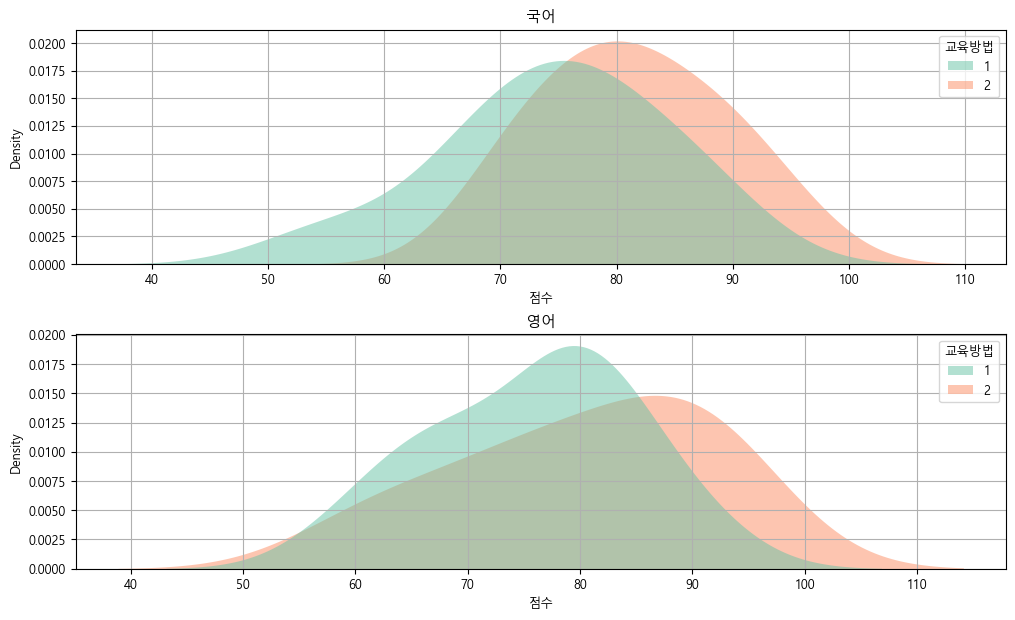

In [283]:
fields = df5_1['과목명'].unique()
f = len(fields)

fig, ax = plt.subplots(f, 1, figsize=(12, 3.5*f))
fig.subplots_adjust(hspace=0.3)


for i, v in enumerate(ax):
    data = df5_1[df5_1['과목명'] == fields[i]]
    sb.kdeplot(data=data, x='점수', hue='교육방법', palette='Set2', 
               fill=True, alpha=.5, linewidth=0, ax=v)
    v.grid()
    v.set_title(f'{fields[i]}')

    
plt.show()
plt.close()

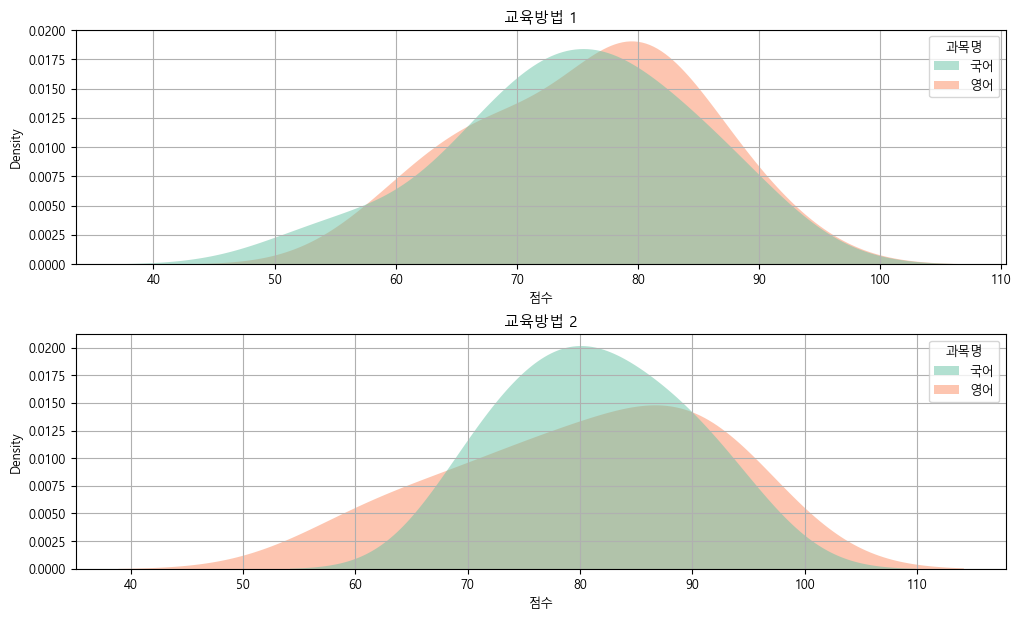

In [ ]:
fields = df5_1['교육방법'].unique()
f = len(fields)

fig, ax = plt.subplots(f, 1, figsize=(12, 3.5*f))
fig.subplots_adjust(hspace=0.3)


for i, v in enumerate(ax):
    data = df5_1[df5_1['교육방법'] == fields[i]]
    sb.kdeplot(data=data, x='점수', hue='과목명', palette='Set2', 
               fill=True, alpha=.5, linewidth=0, ax=v)
    v.grid()
    v.set_title(f'교육방법 {fields[i]}')

    
plt.show()
plt.close()

### [3] 가설검정의 가정 확인

In [284]:
normal_dist = True  
fields = []
for i in df5_1['교육방법'].unique():
    for j in df5_1['과목명'].unique():
        data = df5_1[(df5_1['교육방법'] == i) & (df5_1['과목명'] == j)]['점수']
        fields.append(data)
        s, p = normaltest(data)
        print("[{0} + {1}] statistic: {2:.3f}, p-value: {3:.3f}, 정규성 충족 여부: {4}".format(i, j, s, p, p > 0.05))
        nonormal_dist = normal_dist and (p > 0.05)
if normal_dist:
    s, p = bartlett(*fields)
else:
    s, p = levene(*fields)
print("{f0} Test Result \nstatistic: {0:.3f}, p-value: {1:.3f}, 등분산성 충족 여부: {2}".format(s, p, p > 0.05,f0 = 'bartlett' if normal_dist else 'levene'))

[1 + 국어] statistic: 0.911, p-value: 0.634, 정규성 충족 여부: True
[1 + 영어] statistic: 0.389, p-value: 0.823, 정규성 충족 여부: True
[2 + 국어] statistic: 0.300, p-value: 0.861, 정규성 충족 여부: True
[2 + 영어] statistic: 1.095, p-value: 0.578, 정규성 충족 여부: True
bartlett Test Result 
statistic: 1.253, p-value: 0.740, 등분산성 충족 여부: True


### [4] 분산분석 수행
#### (1) statsmodels 패키지 사용

In [285]:
formula = '점수 ~ C(교육방법)*C(과목명)'
lm = ols(formula, df5_1).fit()
anova_result = anova_lm(lm,typ=2)
anova_result

,sum_sq,df,F,PR(>F)
C(교육방법),355.113636,1.0,3.845870,0.056857
C(과목명),0.204545,1.0,0.002215,0.962695
C(교육방법):C(과목명),14.204545,1.0,0.153835,0.696979
Residual,3693.454545,40.0,NaN,NaN


> 교육방법에 대한 p값이 0.05보다 크므로 교육방법에 따른 성적은 통계적으로 유의미한 차이가 없다.
>
> 과목명에 대한 p값이 0.05보다 크므로 과목에 따른 성적은 통계적으로 유의미한 차이가 없다.
>
> 교육방법과 과목명에 대한 p값이 0.05보다 크므로 교육방법과 과목의 상호작용이 성적에 교효작용이 있다고 볼 수 없다.

#### (2) pingouin 패키지 사용

In [286]:
anova(data=df5_1, dv='점수', between=['교육방법', '과목명'])

,Source,SS,DF,MS,F,p-unc,np2
0,교육방법,355.113636,1,355.113636,3.845870,0.056857,0.087713
1,과목명,0.204545,1,0.204545,0.002215,0.962695,0.000055
2,교육방법 * 과목명,14.204545,1,14.204545,0.153835,0.696979,0.003831
3,Residual,3693.454545,40,92.336364,NaN,NaN,NaN


## 문제 6

서울시에서 정의하는 상권의 종류는 발달상권, 골목상권, 관광특구, 전통시장이 있다.

주어진 데이터는 서울시의 2023년 상권에 따른 분기별 매출액과 매출건수에 대한 자료이다.

> https://data.hossam.kr/mldata/commercial.xlsx

### (1) 상권 종류별 2023년 한 해 동안의 평균 매출액은 어떤 차이가 보이는지 분석하라.



#### [1] 데이터 가져오기

In [288]:
df6 = read_excel('https://data.hossam.kr/mldata/commercial.xlsx')

df6['sales_amount_log'] = np.log(df6['sales_amount'])
df6

,quarter,code,type,name,sales_amount,number_of_sales,sales_amount_log
0,1,3001491,관광특구,이태원 관광특구,72523644100,2496865,25.007178
1,1,3001492,관광특구,명동 남대문 북창동 다동 무교동 관광특구,283332346393,10246122,26.369886
2,1,3001493,관광특구,동대문패션타운 관광특구,81696730221,2880324,25.126280
3,1,3001494,관광특구,종로·청계 관광특구,212062656625,4960006,26.080148
4,1,3001495,관광특구,잠실 관광특구,231338386876,5995166,26.167147
...,...,...,...,...,...,...,...
6217,4,3130323,전통시장,둔촌역전통시장,13523478306,535132,23.327693
6218,4,3130324,전통시장,길동복조리시장,6236556030,330148,22.553694
6219,4,3130325,전통시장,명일전통시장,3973269286,186049,22.102855
6220,4,3130326,전통시장,고덕 골목형상점가,15013907999,755565,23.432243


#### [2] 커널 밀도함수 및 신뢰구간 확인

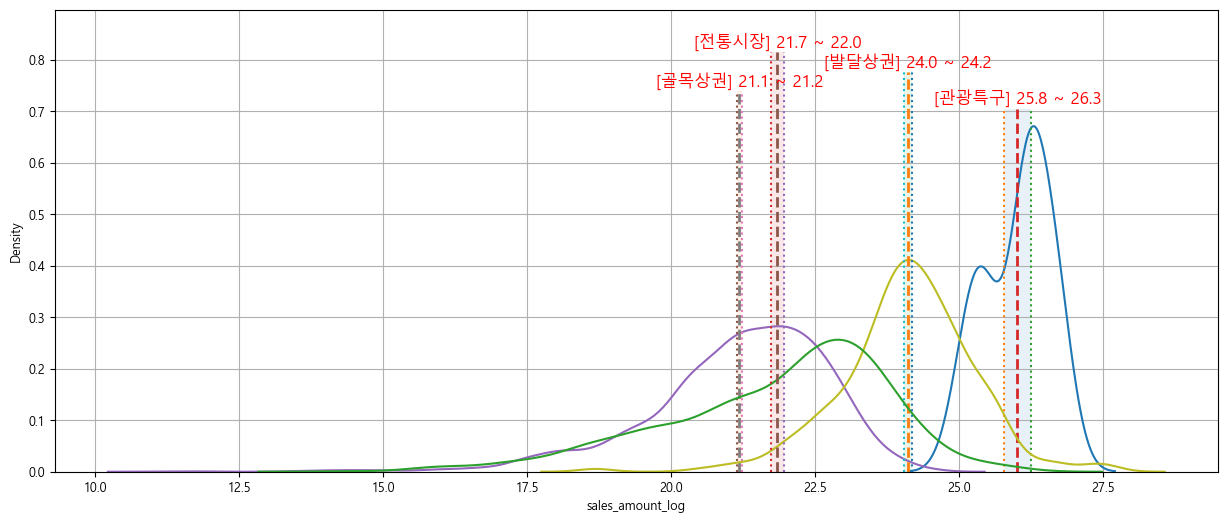

In [291]:
plt.figure()
for c in df6['type'].unique():
    #print(c)
    
    data = df6[df6['type']==c]['sales_amount_log']
    max = data.max()                                # 최대값
    clevel = 0.95                                   # 신뢰수준
    dof = len(data) - 1                             # 자유도
    sample_mean = data.mean()                       # 표본평균
    sample_std = data.std(ddof=1)                   # 표본표준편차
    sample_std_error = sample_std / sqrt(len(data)) # 표본표준오차
    
    # 신뢰구간
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기
    plt.plot([cmin, cmin], [ymin, ymax], linestyle=':')
    plt.plot([cmax, cmax], [ymin, ymax], linestyle=':')
    plt.fill_between([cmin, cmax], y1=ymin, y2=ymax, alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean, sample_mean], [ymin, ymax], linestyle='--', linewidth=2)

    plt.text(x=(cmax-cmin)/2+cmin,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (c, cmin, cmax),
            horizontalalignment="center",
            verticalalignment="bottom",
            fontdict={"size": 12, "color": "red"})

plt.ylim(0, ymax*1.1)
plt.grid()
plt.show()
plt.close()

#### [3] 가설검정의 확인

In [292]:
normal_dist = True
data = []
for i in df6['type'].unique():
    df6_1 = df6[df6["type"] == i]['sales_amount_log']
    s, p = normaltest(df6_1)
    data.append(df6_1)
    print("[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(i, s, p, p > 0.05))
    normal_dist = normal_dist and (p > 0.05)
if normal_dist:
    n = "Bartlett"
    s, p = bartlett(*data)
else:
    n = "Levene"
    s, p = levene(*data)

equal_var = p > 0.05
print("[{0} 검정] statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, equal_var))


[관광특구] statistic: 3.776, p-value: 0.151, 정규성 충족 여부: True
[골목상권] statistic: 850.893, p-value: 0.000, 정규성 충족 여부: False
[발달상권] statistic: 84.529, p-value: 0.000, 정규성 충족 여부: False
[전통시장] statistic: 100.319, p-value: 0.000, 정규성 충족 여부: False
[Levene 검정] statistic: 67.037, p-value: 0.000, 등분산성 충족 여부: False


In [295]:
df6_1 = df6[['type','sales_amount_log']]
df6_1

,type,sales_amount_log
0,관광특구,25.007178
1,관광특구,26.369886
2,관광특구,25.126280
3,관광특구,26.080148
4,관광특구,26.167147
...,...,...
6217,전통시장,23.327693
6218,전통시장,22.553694
6219,전통시장,22.102855
6220,전통시장,23.432243


> 등분산성 가정을 충족하지 않으므로 welch 검정을 통해 평균을 비교해야 한다.

#### [4] 분산분석 수행

In [294]:
welch_anova(data=df6_1,dv='sales_amount_log',between = 'type')

,Source,ddof1,ddof2,F,p-unc,np2
0,type,3,117.954981,1842.976509,7.053276e-99,0.319485


#### [5] 사후검정 수행

In [297]:
result = pairwise_gameshowell(df6_1, dv='sales_amount_log', between='type')
result['results'] = result['pval'] <= 0.05
result # 유의미한 변수 : mean, diff, pval 

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges,results
0,골목상권,관광특구,21.188783,26.018229,-4.829446,0.116139,-41.583473,25.192873,2.220446e-15,-3.087560,True
1,골목상권,발달상권,21.188783,24.111665,-2.922882,0.044081,-66.306856,1987.319203,0.000000e+00,-1.953267,True
2,골목상권,전통시장,21.188783,21.846978,-0.658194,0.062833,-10.475263,1527.837271,0.000000e+00,-0.398660,True
3,관광특구,발달상권,26.018229,24.111665,1.906565,0.119291,15.982446,28.035019,1.121325e-14,1.661959,True
4,관광특구,전통시장,26.018229,21.846978,4.171252,0.127418,32.736855,36.449092,0.000000e+00,2.183914,True
5,발달상권,전통시장,24.111665,21.846978,2.264687,0.068485,33.068280,1844.617220,0.000000e+00,1.407066,True


> 모든 상권의 평균은 통계적으로 유의미한 차이가 있다($P<0.05$)

### (2) 상권 종류별로 2023년 분기별 평균 매출액은 어떤 차이가 보이는지 분석하라.

#### [1] 커널 밀도함수 및 신뢰구간 확인

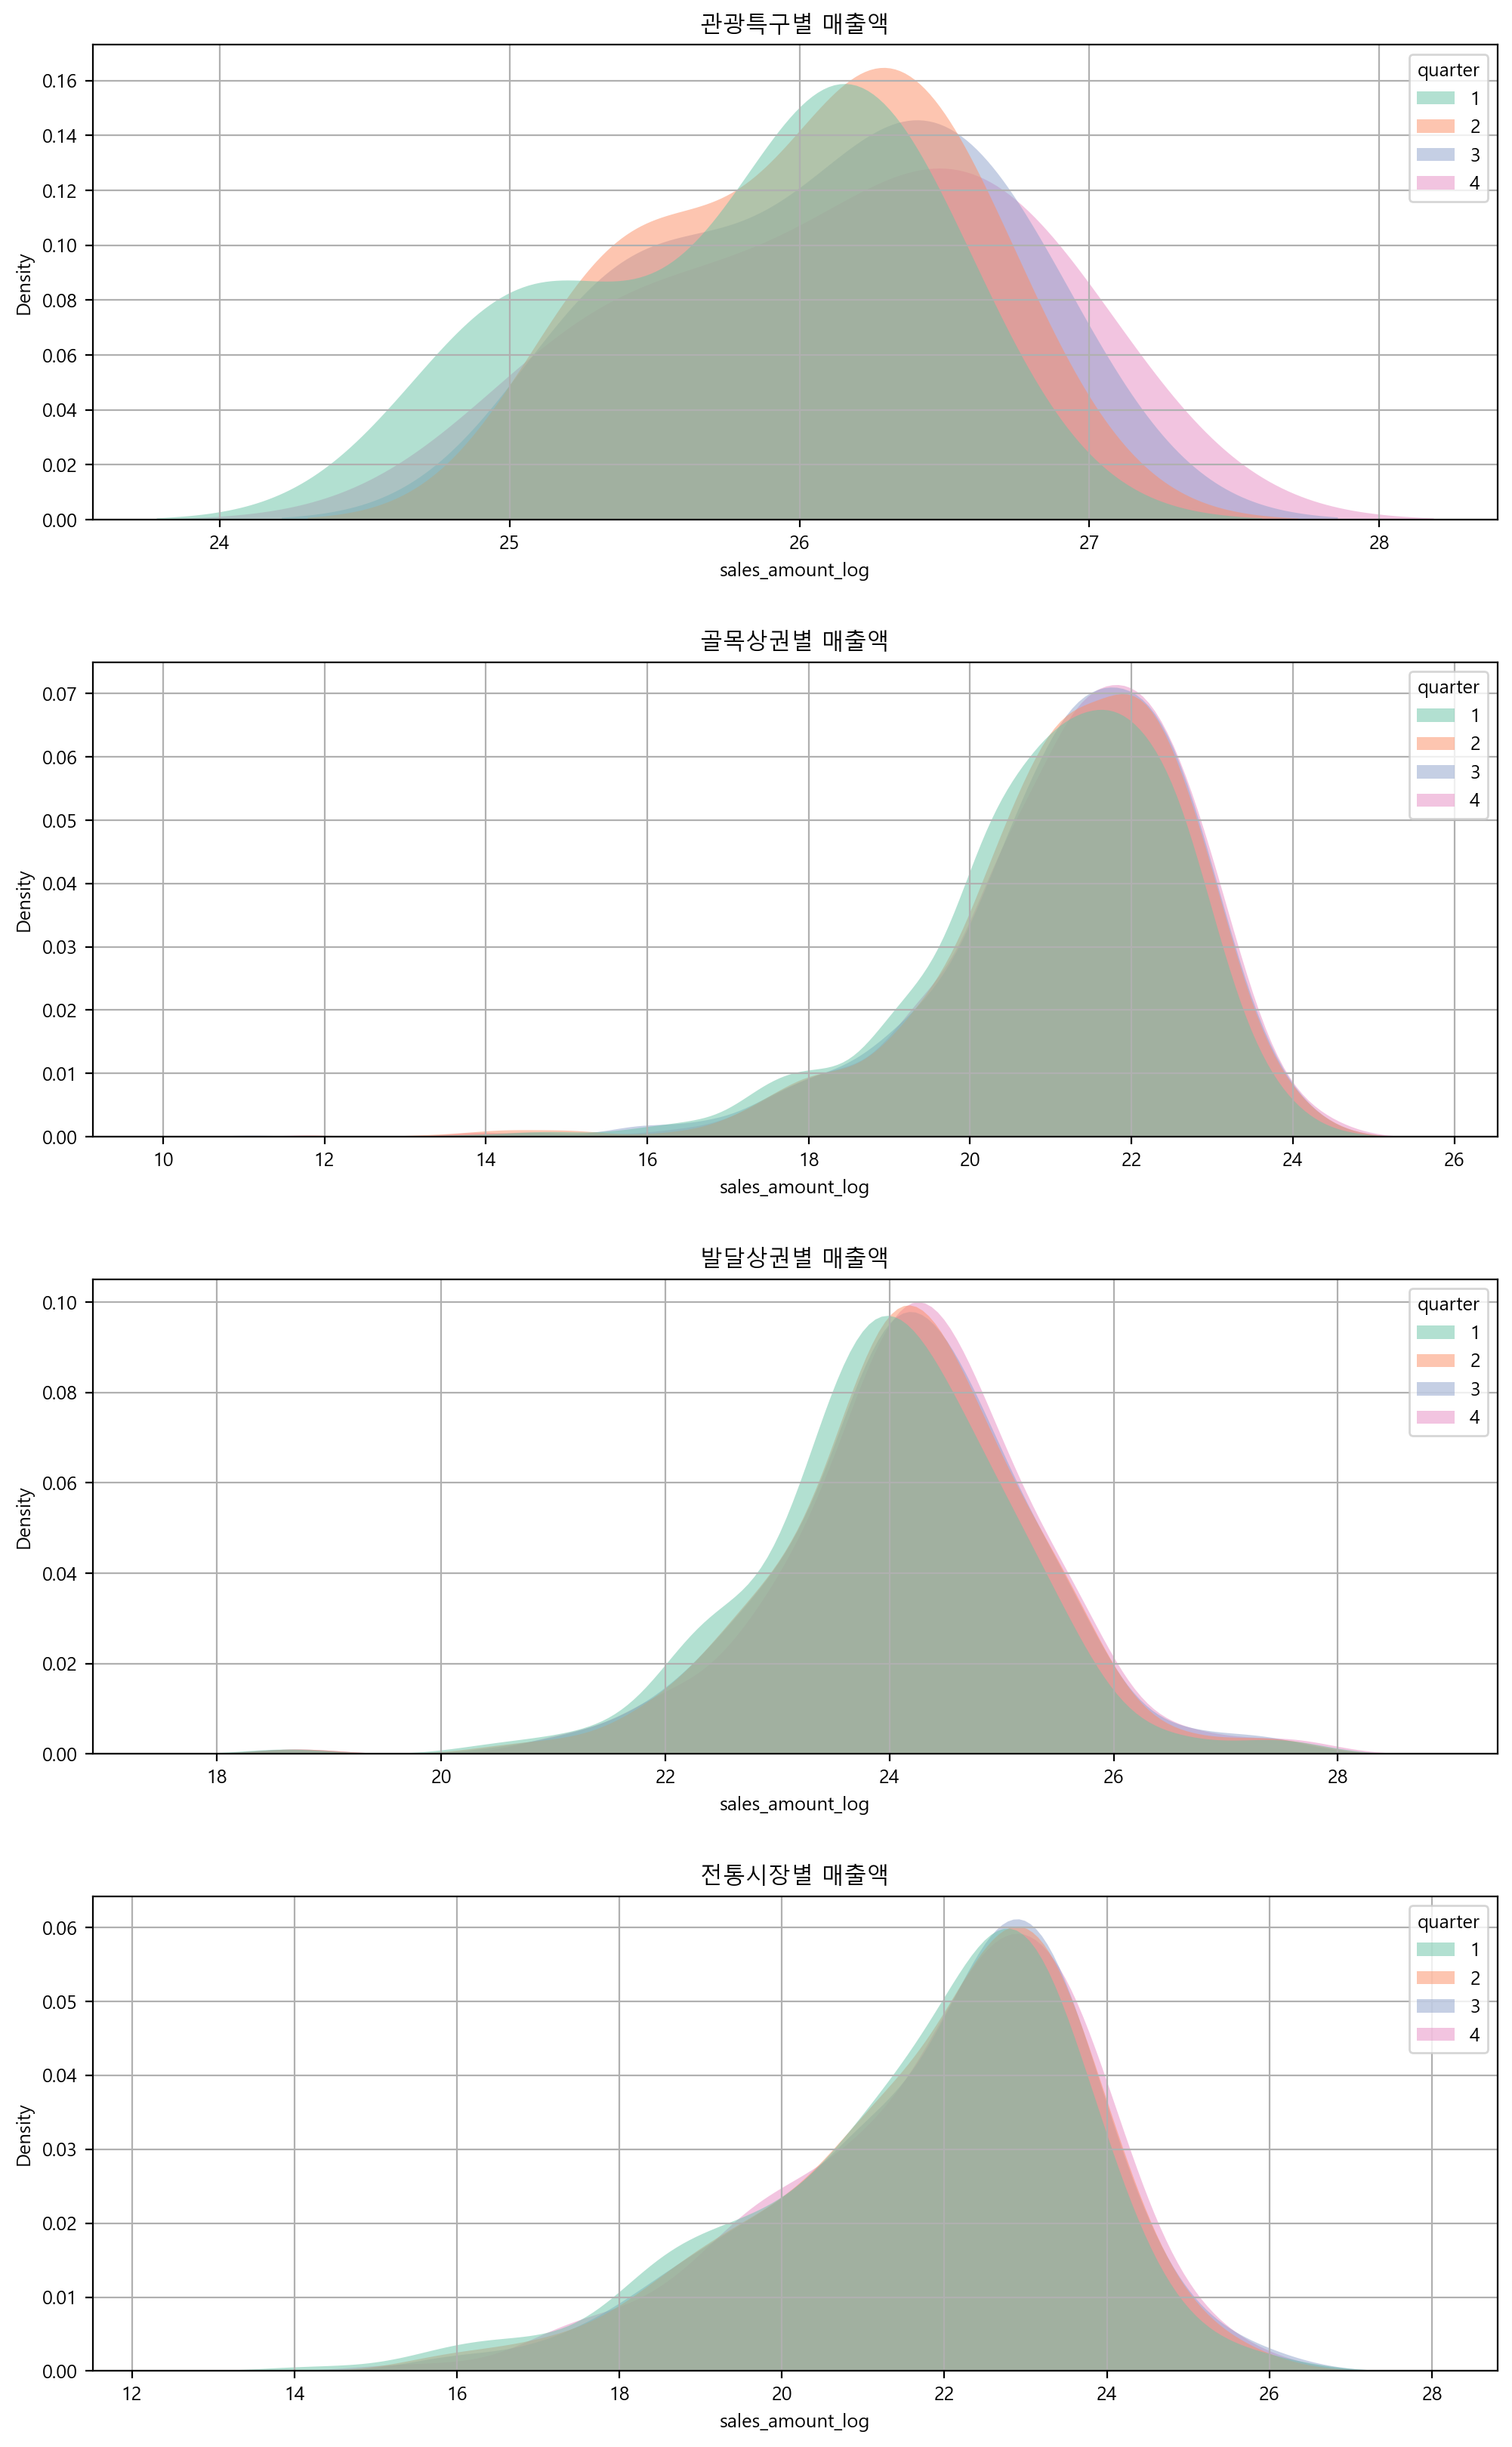

In [300]:
fields = df6['type'].unique()
l = len(fields)
fig, ax = plt.subplots(l, 1, figsize=(12, 5*l), dpi=200)
fig.subplots_adjust(hspace=0.3)

for i, v in enumerate(ax):
    data = df6[df6['type']==fields[i]][['quarter','sales_amount_log']].reset_index(drop=True)
    sb.kdeplot(data=data, x='sales_amount_log', hue='quarter', palette='Set2', 
               fill=True, alpha=.5, linewidth=0, ax=v)
    v.grid()
    v.set_title(f'{fields[i]}별 매출액')
plt.show()
plt.close()

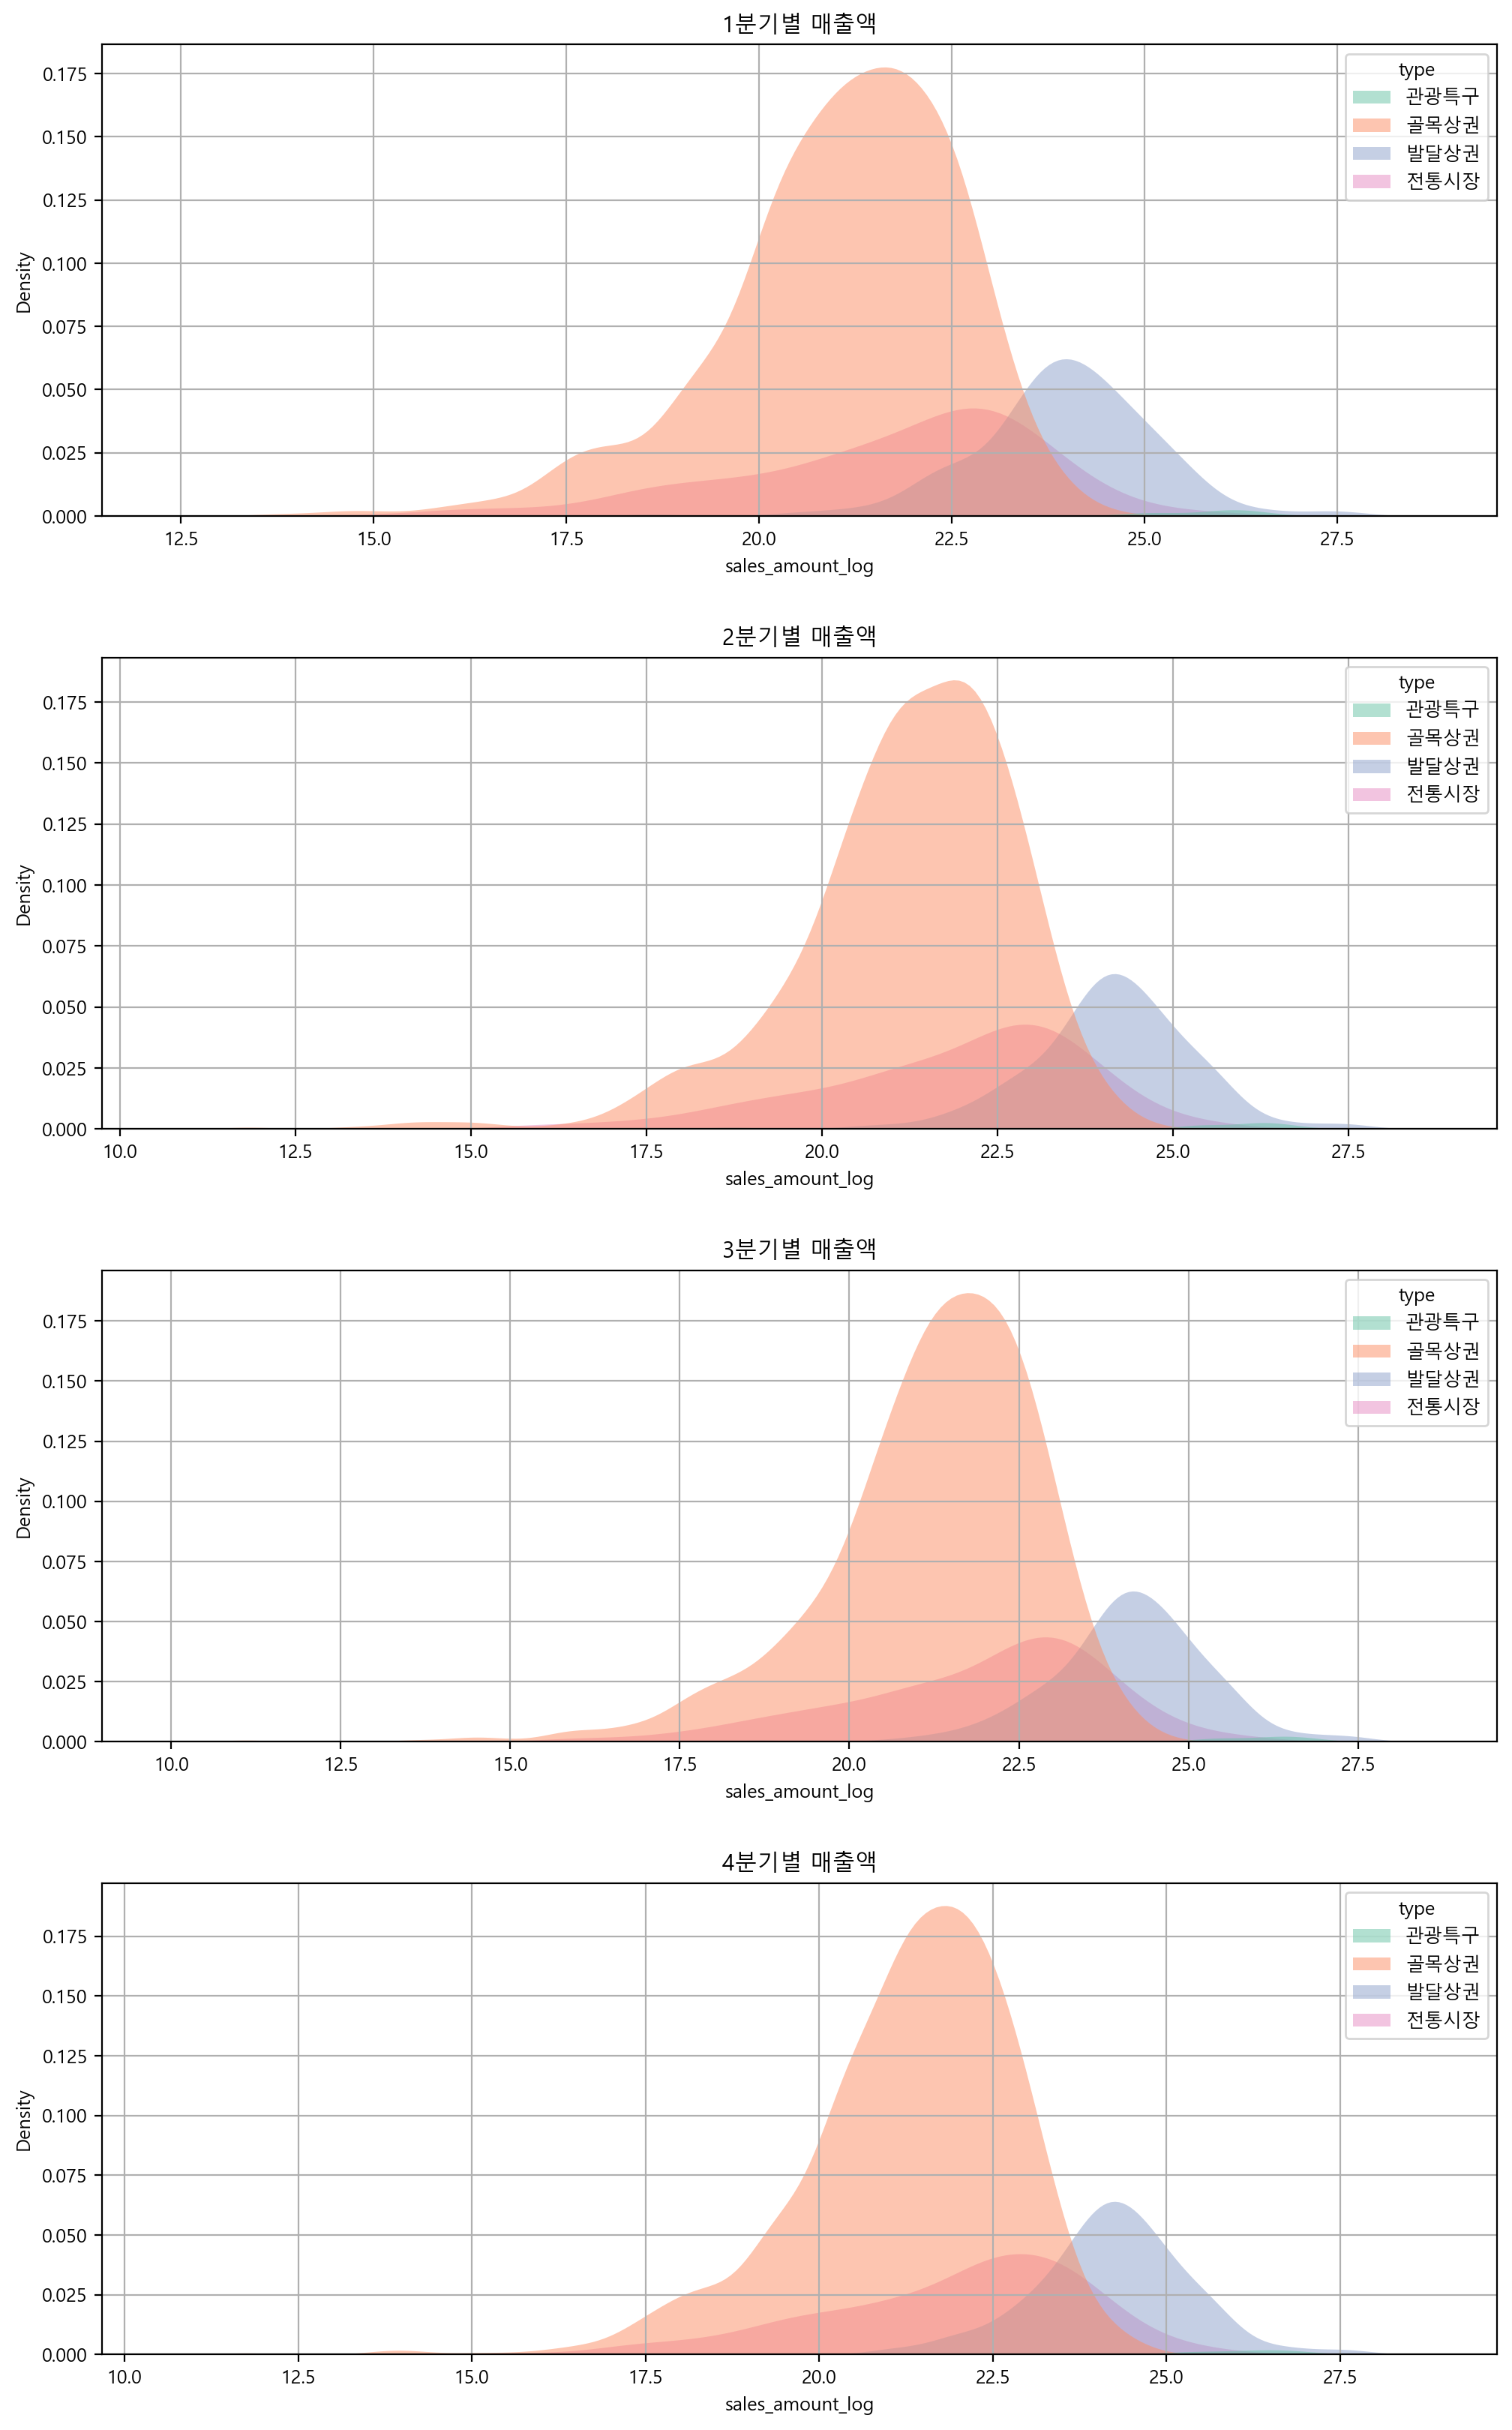

In [301]:
fields = df6['quarter'].unique()
l = len(fields)
fig, ax = plt.subplots(l, 1, figsize=(12, 5*l), dpi=200)
fig.subplots_adjust(hspace=0.3)

for i, v in enumerate(ax):
    data = df6[df6['quarter']==fields[i]][['type','sales_amount_log']].reset_index(drop=True)
    sb.kdeplot(data=data, x='sales_amount_log', hue='type', palette='Set2', 
               fill=True, alpha=.5, linewidth=0, ax=v)
    v.grid()
    v.set_title(f'{fields[i]}분기별 매출액')
plt.show()
plt.close()

In [ ]:
df6

,quarter,code,type,name,sales_amount,number_of_sales
0,1,3001491,관광특구,이태원 관광특구,72523644100,2496865
1,1,3001492,관광특구,명동 남대문 북창동 다동 무교동 관광특구,283332346393,10246122
2,1,3001493,관광특구,동대문패션타운 관광특구,81696730221,2880324
3,1,3001494,관광특구,종로·청계 관광특구,212062656625,4960006
4,1,3001495,관광특구,잠실 관광특구,231338386876,5995166
...,...,...,...,...,...,...
6217,4,3130323,전통시장,둔촌역전통시장,13523478306,535132
6218,4,3130324,전통시장,길동복조리시장,6236556030,330148
6219,4,3130325,전통시장,명일전통시장,3973269286,186049
6220,4,3130326,전통시장,고덕 골목형상점가,15013907999,755565


#### [2] 분산분석 수행

In [306]:
for t in df6['type'].unique():
    print(t)
    print("-" * 30)
    df6_2 = df6[df6['type'] == t][['quarter', 'sales_amount_log']]
    q0 = np.log(df6_2[df6_2['quarter'] == 1]['sales_amount_log'])
    q1 = np.log(df6_2[df6_2['quarter'] == 2]['sales_amount_log'])
    q2 = np.log(df6_2[df6_2['quarter'] == 3]['sales_amount_log'])
    q3 = np.log(df6_2[df6_2['quarter'] == 4]['sales_amount_log'])

    normal_dist = True      # 정규성 만족 여부
    data = [q0, q1, q2, q3]
    
    # 정규성 확인
    for i, c in enumerate(data):
        try:
            s, p = normaltest(c)
            print("[{0}분기] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}".format(i+1, s, p, p > 0.05))
            normal_dist = normal_dist and (p > 0.05)
        except : pass


    # 등분산성 확인
    if normal_dist:
        n = "Bartlett"
        s, p = bartlett(*data)
    else:
        n = "Levene"
        s, p = levene(*data)

    equal_var = p > 0.05
    print("[{0} 검정] statistic: {1:.3f}, p-value: {2:.3f}, 등분산성 충족 여부: {3}".format(n, s, p, equal_var))

관광특구
------------------------------
[Bartlett 검정] statistic: 0.255, p-value: 0.968, 등분산성 충족 여부: True
골목상권
------------------------------
[1분기] statistic: 242.316, p-value: 0.000, 정규성 충족 여부: False
[2분기] statistic: 428.512, p-value: 0.000, 정규성 충족 여부: False
[3분기] statistic: 419.145, p-value: 0.000, 정규성 충족 여부: False
[4분기] statistic: 385.273, p-value: 0.000, 정규성 충족 여부: False
[Levene 검정] statistic: 0.219, p-value: 0.883, 등분산성 충족 여부: True
발달상권
------------------------------
[1분기] statistic: 40.341, p-value: 0.000, 정규성 충족 여부: False
[2분기] statistic: 45.910, p-value: 0.000, 정규성 충족 여부: False
[3분기] statistic: 43.740, p-value: 0.000, 정규성 충족 여부: False
[4분기] statistic: 45.130, p-value: 0.000, 정규성 충족 여부: False
[Levene 검정] statistic: 0.037, p-value: 0.991, 등분산성 충족 여부: True
전통시장
------------------------------
[1분기] statistic: 56.806, p-value: 0.000, 정규성 충족 여부: False
[2분기] statistic: 44.393, p-value: 0.000, 정규성 충족 여부: False
[3분기] statistic: 39.606, p-value: 0.000, 정규성 충족 여부: False
[4분기] statistic: 42.394

In [ ]:
lm = ols('sales_amount_log ~ C(type)*C(quarter)', df6).fit()
anova_result = anova_lm(lm, tpy=2)
anova_result

,df,sum_sq,mean_sq,F,PR(>F)
C(type),3.0,3.397583e+24,1.132528e+24,612.997343,0.000000
C(quarter),3.0,6.915692e+21,2.305231e+21,1.247740,0.290658
C(type):C(quarter),9.0,3.140937e+22,3.489930e+21,1.888976,0.048918
Residual,6206.0,1.146574e+25,1.847525e+21,NaN,NaN


> 상권 종류별에 대한 p값이 0.05보다 작으므로 상권 종류별에 따른 매출액의 평균은 통계적으로 유의미한 차이가 있다
>
> 분기별에 대한 p값이 0.05보다 크므로 분기별에 대한 매출액의 평균은 통계적으로 유의미한 차이가 없다
>
> 상권종류별과 분기별에 대한 p값이 0.05보다 작으므로 상권종류별과 분기별의 매출액에 교효작용이 있다고 볼 수 있다.


In [307]:
anova(df6, dv='sales_amount_log', between = ['type','quarter'])

,Source,SS,DF,MS,F,p-unc,np2
0,type,7280.936898,3.0,2426.978966,974.388118,0.000000,0.320201
1,quarter,49.935651,3.0,16.645217,6.682753,0.000168,0.003220
2,type * quarter,0.426489,9.0,0.047388,0.019025,1.000000,0.000028
3,Residual,15457.733100,6206.0,2.490772,NaN,NaN,NaN
